# **Machine Translation using Transformer-**

In [ ]:
%matplotlib inline
!python -m pip install --upgrade pip
!python -m pip install torchtext==0.6.0
!python -m pip install einops
!python -m pip install spacy
!python -m spacy download en
!python -m spacy download fr
!python -m spacy download de

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 12.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full p

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import math
from einops import rearrange
import matplotlib.pyplot as plt

In [ ]:
import spacy
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

In [ ]:
SRC = Field(tokenize = "spacy",
            tokenizer_language="de_core_news_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en_core_web_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 5.56MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.77MB/s]

downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.57MB/s]


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
print(vars(train_data.examples[64]))

{'src': ['eine', 'frau', 'in', 'einer', 'roten', 'windjacke', ',', 'die', 'über', 'ein', 'auf', 'einem', 'dach', 'installiertes', 'fernrohr', 'auf', 'die', 'darunterliegende', 'stadt', 'blickt', '.'], 'trg': ['woman', 'in', 'red', 'windbreaker', 'looking', 'though', 'a', 'rooftop', 'binoculars', 'at', 'the', 'city', 'below', '.']}


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
# Printing a list of tokens mapping integer to strings
print(SRC.vocab.itos)
# Printing a dict mapping tokens to indices
print(SRC.vocab.stoi)
# Printing the index of an actual word
print(SRC.vocab.stoi['ein'])

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',', 'und', 'mit', 'auf', 'mann', 'einer', 'der', 'frau', 'die', 'zwei', 'einen', 'im', 'an', 'von', 'sich', 'dem', 'mädchen', 'junge', 'vor', 'zu', 'steht', 'männer', 'sitzt', 'hund', 'den', 'straße', 'während', 'gruppe', 'hält', 'spielt', 'das', 'hemd', 'personen', 'über', 'drei', 'eines', 'frauen', 'blauen', 'neben', 'ist', 'kind', 'roten', 'weißen', 'stehen', 'sitzen', 'menschen', 'am', 'aus', 'spielen', 'durch', 'bei', 'geht', 'trägt', 'fährt', 'wasser', 'um', 'kinder', 'kleines', 'person', 'macht', 'springt', 'kleiner', 'schwarzen', 'entlang', 'leute', 'gehen', 'etwas', 'mehrere', 'seinem', 'großen', 'oberteil', 'jungen', 'hand', 'grünen', 'läuft', 'sind', 'für', 'hintergrund', 'fahrrad', 'freien', 'jacke', 'luft', 'strand', 'ball', 'hat', 'anderen', 'schaut', 'junger', 'kleidung', 'hinter', 'sie', 'nach', 'andere', 'gelben', 'kleine', 'gebäude', 'vier', 'hut', 'tisch', 'wird', 'beim', 'nähe', 'essen', 'klein

In [ ]:
def TabularFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Validation loss','Validation Accuracy'])

In [ ]:
def GraphicalFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)

  plt.figure(figsize =(12,7))
  plt.plot(ep,eval_cost,label = "Evaluation Loss")
  plt.plot(ep,train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between value of Trainig and Validation Loss V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(12,7))
  plt.plot(ep,train_acc,label = "Training Accuracy")
  plt.plot(ep,eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between Trainig and Validation Accuracies V/s Epochs",fontsize = 15)
  plt.show()

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(INPUT_DIM, ENC_EMB_DIM)
        self.tgt_embedding = nn.Embedding(INPUT_DIM, ENC_EMB_DIM)
        self.transformer = nn.Transformer(nhead=8, num_encoder_layers=2, d_model=ENC_EMB_DIM)
        self.linear = nn.Linear(ENC_EMB_DIM, OUTPUT_DIM)
        pos_dropout = 0.1
        max_seq_length = 128
        self.pos_enc = PositionalEncoding(ENC_EMB_DIM, pos_dropout, max_seq_length)
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_mask=None):
        # TODO: Investigate masks, positional encoding, understand Rearrange(), debug model output (output has negative numbers for some reason)
        # Original src shape: (sentence length=24?, batch_size=128)
        # Original tgt shape: (sentence length=24?, batch_size=128)
        # Transformer expects: (sentence length=24, batch_size=128, embedding_size=128)
        src_emb = self.pos_enc(self.src_embedding(src) * math.sqrt(ENC_EMB_DIM))
        tgt_emb = self.pos_enc(self.tgt_embedding(tgt) * math.sqrt(ENC_EMB_DIM))
        out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        out = self.linear(out)
        return out

  

model = TransformerModel().to(device)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


dash = "________________________________________________________________________\n\n"
print(dash)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The overall model is - 

TransformerModel(
  (src_embedding): Embedding(7853, 32)
  (tgt_embedding): Embedding(7853, 32)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear

In [ ]:
# Checking index of special tokens
PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']
UNK_IDX = TRG.vocab.stoi['<unk>']
print('pad index:', PAD_IDX)
print('sos index:', SOS_IDX)
print('eos index:', EOS_IDX)
print('unk index:', UNK_IDX)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

pad index: 1
sos index: 2
eos index: 3
unk index: 0


In [ ]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask

In [ ]:
def example_translate(model, example_sentence_src):
    # Translate example sentence
    example_tensor_src = string_to_indices(SRC, example_sentence_src).view(-1, 1)
    example_sentence_tgt = '<sos>'
    example_tensor_tgt = string_to_indices(TRG, example_sentence_tgt).view(-1, 1)
    src = example_tensor_src.to(device)
    tgt = example_tensor_tgt.to(device)

    # print('----------Translating--------------')
    for i in range(128):
        # print('Src:', src)
        # print('Tgt:', tgt)
        src_key_padding_mask = src == PAD_IDX
        tgt_key_padding_mask = tgt == PAD_IDX
        memory_key_padding_mask = src_key_padding_mask.clone()
        src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n')
        tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n')
        memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n')
        tgt_mask = gen_nopeek_mask(tgt.shape[0]).to('cuda')
        # print('Tgt mask:', tgt_mask)

        output = model(src, tgt, 0, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask) #turn off teacher forcing

        # print('Output:', output)
        # TODO: Check that the argmax line is correct
        output_index = torch.argmax(output, dim=2)[-1].item()
        output_word = TRG.vocab.itos[output_index]
        example_sentence_tgt = example_sentence_tgt + ' ' + output_word
        # print('Translated sentence so far:', example_sentence_tgt)
        example_tensor_tgt = string_to_indices(TRG, example_sentence_tgt).view(-1, 1)
        tgt = example_tensor_tgt.to(device)
        if output_word == '<eos>':
            print('Translated sentence so far:', example_sentence_tgt)
            break
    print('-----------Finished Translating--------------')

In [ ]:
from torchtext.data.metrics import bleu_score
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    # rounded_preds = torch.round(torch.sigmoid)
    bleu_score(preds, y)
    print("BLEU Score: ",bleu_score)
    # correct = (preds == y).float() #convert into float for division 
    # acc = (correct.sum() / len(correct))*100
    acc = bleu_score*100
    return acc

In [ ]:
import math
import time

def indices_to_string(LANGUAGE, batch):
    words_list = []
    for sentence in batch.transpose(1, 0):
        sentence_list = sentence.tolist()
        words = []
        for index in sentence_list:
            word = LANGUAGE.vocab.itos[index]
            words.append(word)
        words_list.append(words)
    return words_list

def string_to_indices(LANGUAGE, sentence):
    words = sentence.split()
    indices = []
    for word in words:
        if word in LANGUAGE.vocab.stoi:
            index = LANGUAGE.vocab.stoi[word]
            indices.append(index)
        else:
            index = LANGUAGE.vocab.stoi['<unk>']
            indices.append(index)
    result = torch.tensor(indices)
    return result

def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    epoch_acc = 0

    for _, batch in enumerate(iterator):

        src = batch.src
        tgt = batch.trg

        optimizer.zero_grad()

        # Original src shape: (sentence length=24, batch_size=128)
        # Transformer expects: (sentence length=24, batch_size=128, embedding_size=128)
        src_key_padding_mask = src == PAD_IDX
        tgt_key_padding_mask = tgt == PAD_IDX
        memory_key_padding_mask = src_key_padding_mask.clone()
        src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n')
        tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n')
        memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n')
        tgt_sentence_len = tgt.shape[0] - torch.sum(tgt_key_padding_mask, axis=1)
        tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]
        tgt_key_padding_mask = tgt_key_padding_mask[:, :-1]
        tgt_mask = gen_nopeek_mask(tgt_inp.shape[0]).to('cuda')
        output = model(src, tgt_inp, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask)
        from_one_hot = torch.argmax(output, dim=2)
        # output shape: (sentence length=24, batch_size=128, vocab=5893)
        # Original tgt shape: (sentence length=24, batch_size=128)

        output = output.view(-1, output.shape[-1])
        tgt_out = tgt_out.view(-1)

        loss = criterion(output, tgt_out)
        # acc = binary_accuracy(output, tgt_out)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        # epoch_acc += acc.item()

    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)



def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    print('Evaluating')
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            tgt = batch.trg

            src_key_padding_mask = src == PAD_IDX
            tgt_key_padding_mask = tgt == PAD_IDX
            memory_key_padding_mask = src_key_padding_mask.clone()
            src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n')
            tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n')
            memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n')
            tgt_mask = gen_nopeek_mask(tgt.shape[0]).to('cuda')
            output = model(src, tgt, 0, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask) #turn off teacher forcing
            from_one_hot = torch.argmax(output, dim=2)
            #print(src.shape, output.shape, from_one_hot.shape, tgt.shape)

            output = output[1:].view(-1, output.shape[-1])
            #print('Src:', src.transpose(1, 0))
            #print('Predicted:', from_one_hot.transpose(1, 0))
            #print('Target:', tgt.transpose(1, 0))
            src_words = indices_to_string(SRC, src)
            predicted_words = indices_to_string(TRG, from_one_hot)
            tgt_words = indices_to_string(TRG, tgt)
            #for i, src in enumerate(src_words):
            #    print('----------------------------------')
            #    print(' '.join(src))
            #    print(' '.join(predicted_words[i]))
            #    print(' '.join(tgt_words[i]))

            tgt = tgt[1:].view(-1)
            loss = criterion(output, tgt)
            # acc = binary_accuracy(output, tgt_out)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
from torchtext.data.metrics import bleu_score

In [ ]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion,CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    # train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    # valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')#' | Train Acc: {train_acc:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}')# |  Val. Acc: {valid_acc:.2f}%')

Evaluating
Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 5.888
	 Val. Loss: 5.805
Evaluating
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 4.162
	 Val. Loss: 6.728
Evaluating
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 3.665
	 Val. Loss: 7.231
Evaluating
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 3.329
	 Val. Loss: 7.520
Evaluating
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 3.072
	 Val. Loss: 7.828
Evaluating
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 2.851
	 Val. Loss: 8.108
Evaluating
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 2.667
	 Val. Loss: 8.315
Evaluating
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 2.518
	 Val. Loss: 8.530
Evaluating
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 2.386
	 Val. Loss: 8.734
Evaluating
Epoch: 10 | Epoch Time: 0m 14s
	Train Loss: 2.274
	 Val. Loss: 8.863


In [ ]:
def TabularFormat(epochs,train_cost,eval_cost):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,eval_cost)),columns = ['Epoch Value','Training Loss','Validation loss'])

In [ ]:
def GraphicalFormat(epochs,train_cost,eval_cost):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)

  plt.figure(figsize =(12,7))
  plt.plot(ep,eval_cost,label = "Evaluation Loss")
  plt.plot(ep,train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between value of Trainig and Validation Loss V/s Epochs",fontsize = 15)
  # plt.show()
  # print("\n\n__________________________________________________\n\n")
  # plt.figure(figsize =(12,7))
  # plt.plot(ep,train_acc,label = "Training Accuracy")
  # plt.plot(ep,eval_acc,label = "Evaluation Accuracy")
  # plt.ylabel("Accuracy",fontsize = 15)
  # plt.xlabel("No. of Epoch",fontsize = 15)
  # plt.legend(fontsize = 12,loc = "best")
  # plt.title("Graph between Trainig and Validation Accuracies V/s Epochs",fontsize = 15)
  # plt.show()

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,valid_loss_list)
pd

,Epoch Value,Training Loss,Validation loss
0,1,5.887678,5.804873
1,2,4.161577,6.728456
2,3,3.664545,7.231285
3,4,3.329426,7.520477
4,5,3.071833,7.827762
5,6,2.851272,8.108031
6,7,2.666910,8.314574
7,8,2.518156,8.530499
8,9,2.386016,8.733790
9,10,2.273850,8.863477


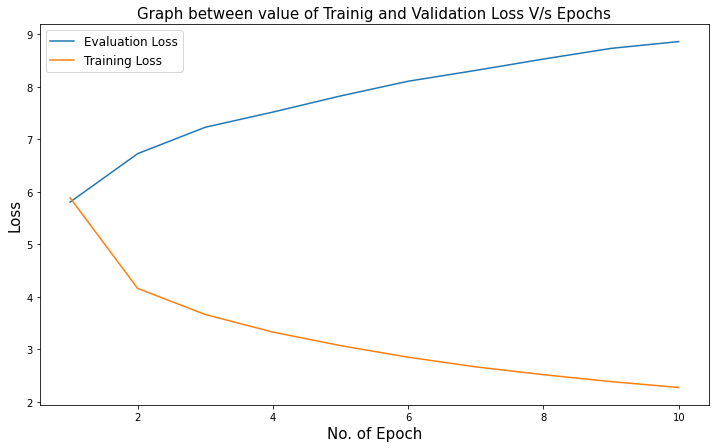

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,valid_loss_list)

In [ ]:
example_sentence_src = '<sos> der himmel ist blau <eos>'
example_translate(model, example_sentence_src)

Translated sentence so far: <sos> the man is in the blue is in the background . <eos>
-----------Finished Translating--------------


In [ ]:
example_sentence_src = '<sos> viele menschen haben sich versammelt <eos>'
example_translate(model, example_sentence_src)

Translated sentence so far: <sos> many people are gathered around . <eos>
-----------Finished Translating--------------


In [ ]:
example_sentence_src = '<sos> das nicht auf dem foto ist <eos>'
example_translate(model, example_sentence_src)

Translated sentence so far: <sos> the picture is on the window . <eos>
-----------Finished Translating--------------
